# MM samples
1 Logistic PCA
2 NMF results
3 Survival Analysis
4 Age BMPC%
5 Drug Response

In [1]:
library(dplyr)
library(Seurat)
library(patchwork)
library(ggplot2)
library(cowplot)
library(survival)
library(survminer)
library(openxlsx)
library(ggpubr)
library(RColorBrewer)
library("rARPACK")
library("logisticPCA")
source('survplotPCD.R')


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Attaching SeuratObject


Attaching package: ‘cowplot’


The following object is masked from ‘package:patchwork’:

    align_plots


Loading required package: ggpubr


Attaching package: ‘ggpubr’


The following object is masked from ‘package:cowplot’:

    get_legend




In [2]:
MMgroups<-read.xlsx('Table S3-re.xlsx', sheet = 1, startRow = 1, colNames = TRUE, rowNames = FALSE)
rownames(MMgroups)<-MMgroups$newID

In [3]:
meta<-read.csv('PCDalllist-wxz0513.csv',header=T)
rownames(meta)<-meta$newID
metaMM<-meta[which(meta$diagnosis=='MM'),]

In [4]:
all<-read.csv('0429-snp-allmut-together-bi.csv')
rownames(all)<-all$X
all$X<-NULL
all<-all[,metaMM$newID]
all<-all[which(rowSums(all)>0.02*163),]

In [5]:
MMifish<-read.csv(file='1207-MMifish.csv')
rownames(MMifish)<-MMifish$X
MMifish$X<-NULL

In [6]:
normal <- CreateSeuratObject(counts =all, project = "normal",min.cells = 1)
normal@meta.data<-cbind(normal@meta.data,metaMM[rownames(normal@meta.data),])
normal@meta.data<-cbind(normal@meta.data,MMgroups[rownames(normal@meta.data),])
normal@meta.data<-cbind(normal@meta.data,MMifish[rownames(normal@meta.data),])
suppressMessages(normal <- ScaleData(normal, features = rownames(all)))
suppressMessages(normal <- RunPCA(normal, features = rownames(all),npcs = 2))

Warning message in print.DimReduc(x = reduction.data, dims = ndims.print, nfeatures = nfeatures.print):
“Only 2 dimensions have been computed.”
Warning message:
“Requested number is larger than the number of available items (49). Setting to 49.”
Warning message:
“Requested number is larger than the number of available items (49). Setting to 49.”


In [7]:
set.seed(42)
X.df <- as.data.frame(t(all))
X <- as.matrix(sapply(X.df, as.numeric))
# Determine m via logisticSVD
logsvd_model = logisticSVD(X, k = 2)
logpca_cv = cv.lpca(X, ks = 2, ms = 1:10)
#write.table(logpca_cv, file.path(args$outdir, "logistic_pca_cv_nll.tsv") ,sep='\t')

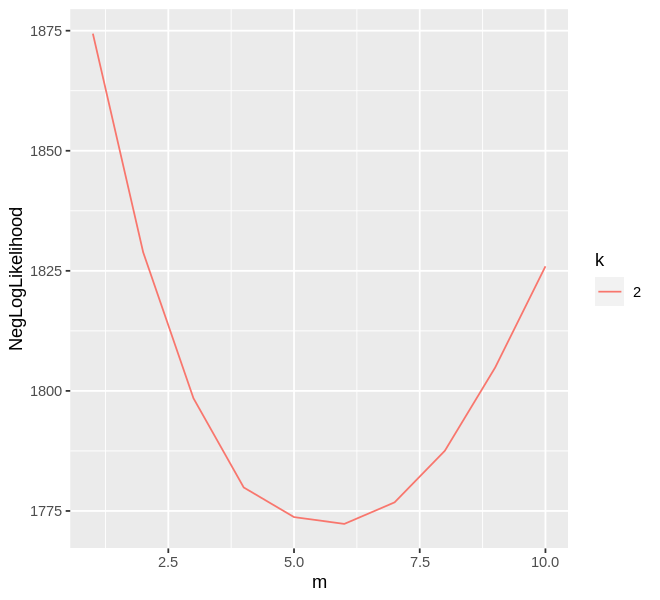

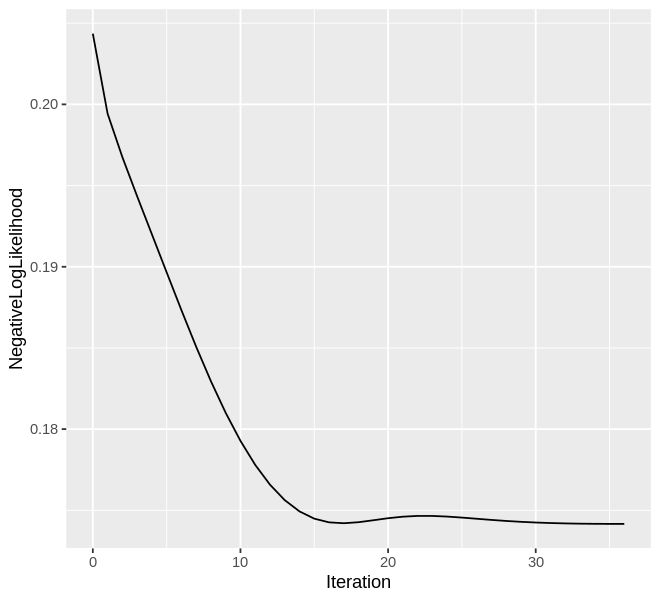

In [8]:
options(repr.plot.height=5,repr.plot.width=5.5)
# Run logistic PCA models (we  use logPCA, not convexLogisticPCA)
logpca_model = logisticPCA(X, k = 2, m = which.min(logpca_cv))
clogpca_model = convexLogisticPCA(X, k = 2, m = which.min(logpca_cv))
plot(logpca_cv)
plot(clogpca_model, type = "trace")

In [9]:
# Write out Results for PCA Loadings & PCA Components
logpca_modelPCs<-as.data.frame(logpca_model$PCs)
rownames(logpca_modelPCs) <- rownames(X.df)
colnames(logpca_modelPCs) <- c('PC_1','PC_2')
normal@reductions$pca@cell.embeddings<-as.matrix(logpca_modelPCs[rownames(normal@meta.data),])
normal@meta.data$center<-substring(normal@meta.data$ID,1,5)

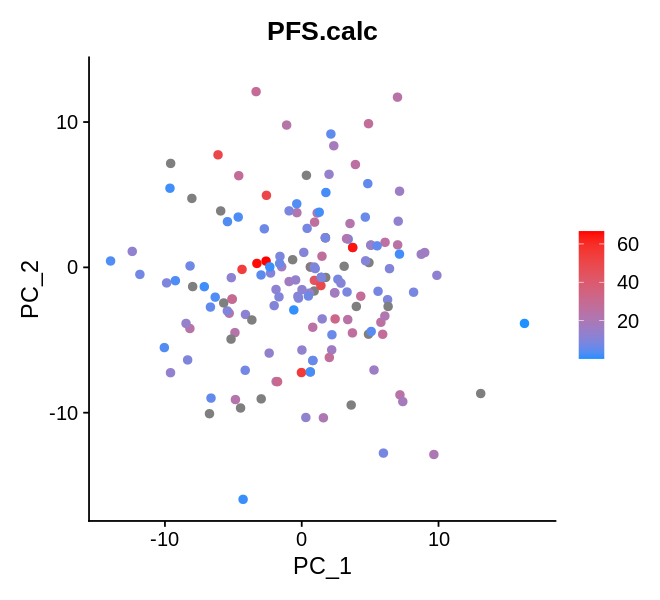

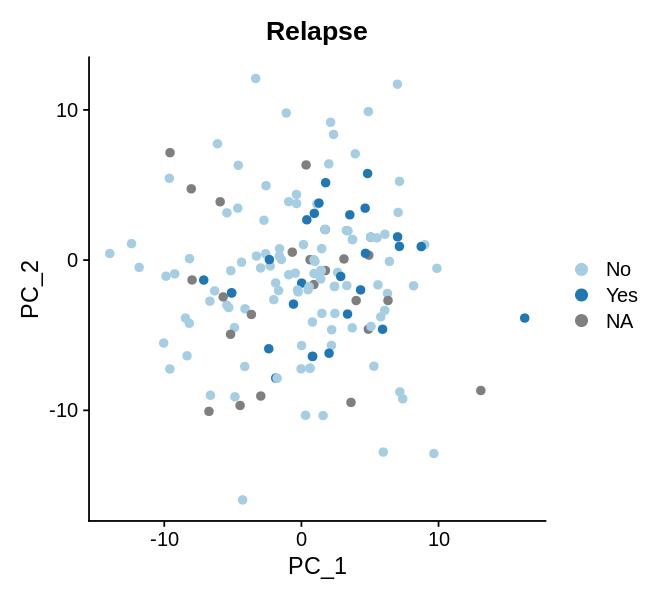

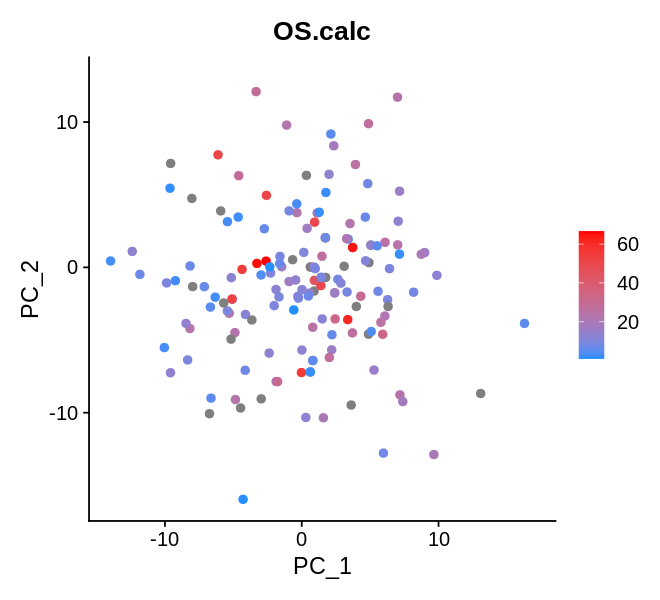

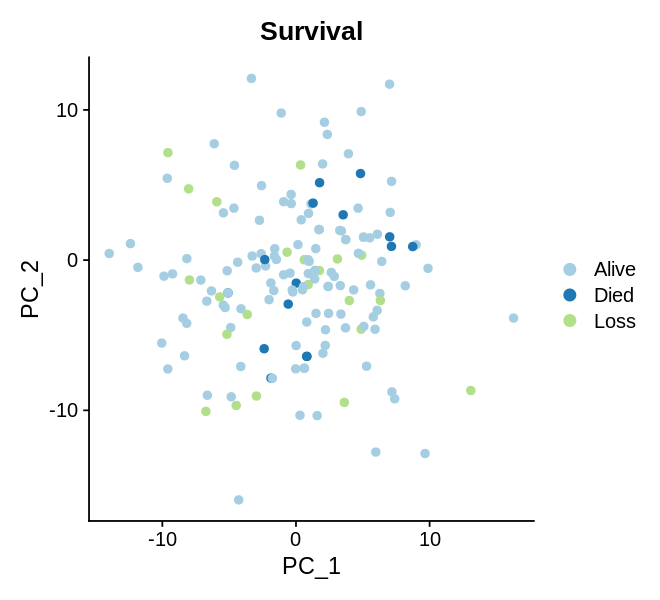

In [10]:
options(repr.plot.height=5,repr.plot.width=5.5)
FeaturePlot(normal,reduction='pca',feature='PFS.calc',cols=c('dodgerblue','red'),pt.size=2)
DimPlot(normal, reduction = "pca",group.by='Relapse',label=F,pt.size=2,cols=brewer.pal(3,"Paired"))
FeaturePlot(normal,reduction='pca',feature='OS.calc',cols=c('dodgerblue','red'),pt.size=2)
DimPlot(normal, reduction = "pca",group.by='Survival',label=F,pt.size=2,cols=brewer.pal(3,"Paired"))

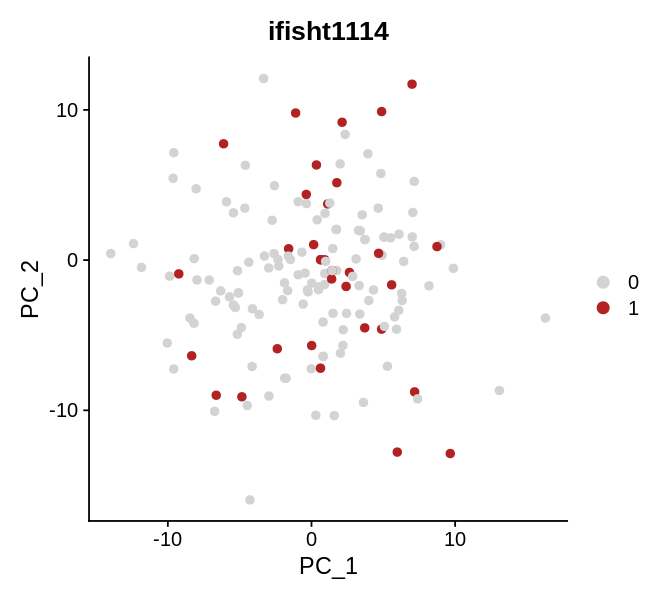

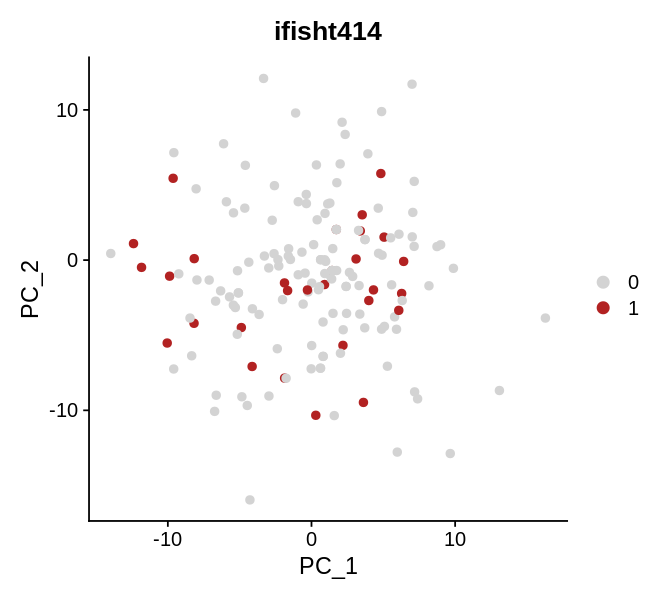

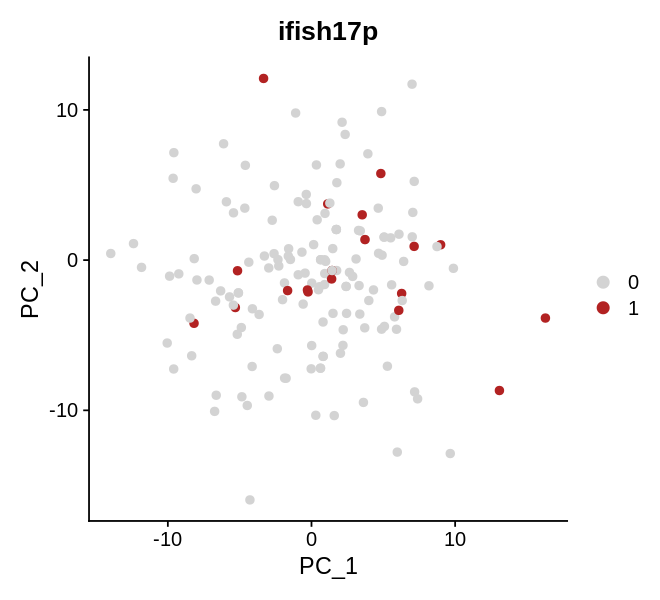

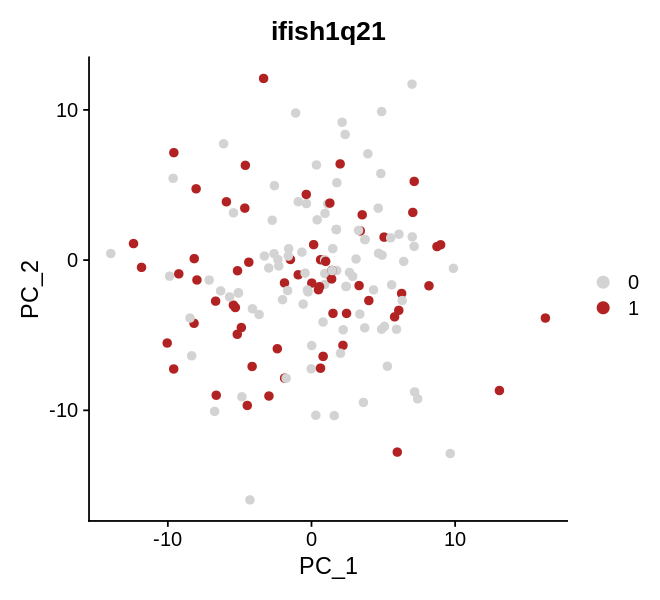

In [11]:
options(repr.plot.height=5,repr.plot.width=5.5)
DimPlot(normal, reduction = "pca",group.by='ifisht1114',label=F,pt.size=2,cols=c('lightgrey','firebrick'))
DimPlot(normal, reduction = "pca",group.by='ifisht414',label=F,pt.size=2,cols=c('lightgrey','firebrick'))
DimPlot(normal, reduction = "pca",group.by='ifish17p',label=F,pt.size=2,cols=c('lightgrey','firebrick'))
DimPlot(normal, reduction = "pca",group.by='ifish1q21',label=F,pt.size=2,cols=c('lightgrey','firebrick'))

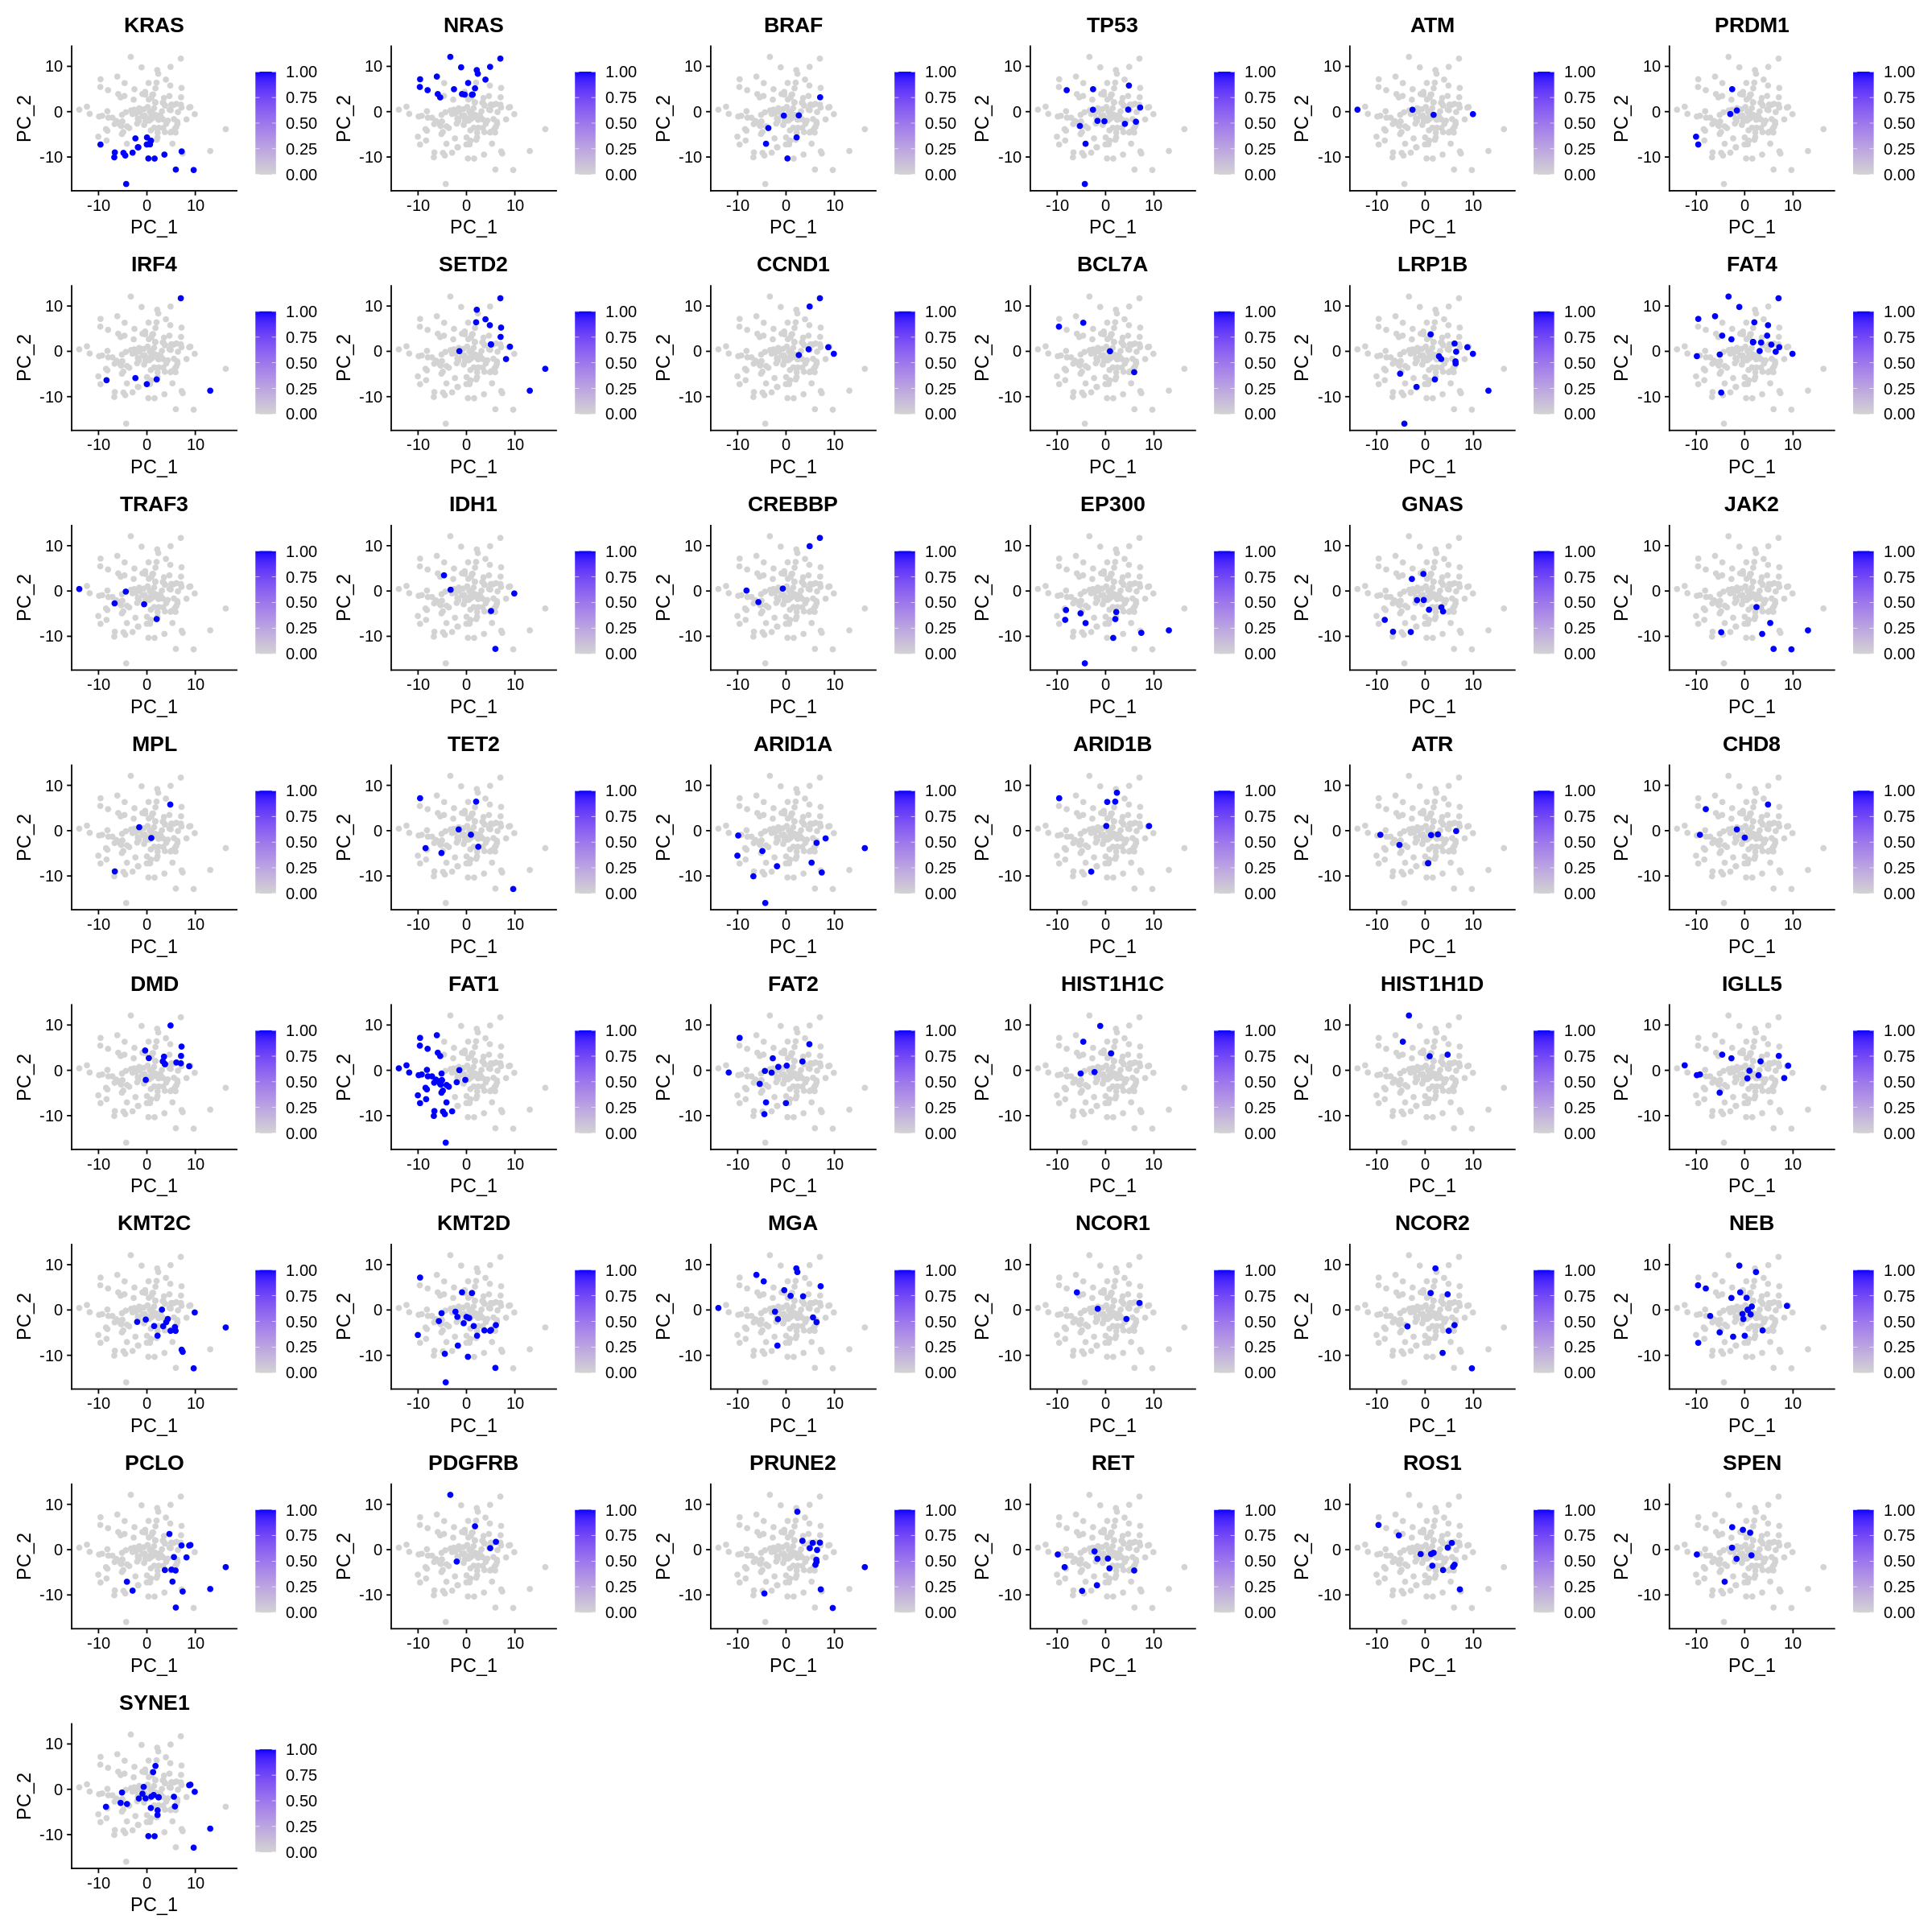

In [12]:
options(repr.plot.height=20,repr.plot.width=20)
NMCHIP<-read.csv('NMCHIP.csv',header=T)
FeaturePlot(normal, reduction = "pca",features=intersect(rownames(all),NMCHIP$Gene),label=F,pt.size=1.5,order=T,ncol=6)

In [13]:
dim(all)
write.table(as.data.frame(t(all)), file='test_MM_loh.tsv', quote=FALSE, sep='\t', col.names = NA)

[1]  49 163

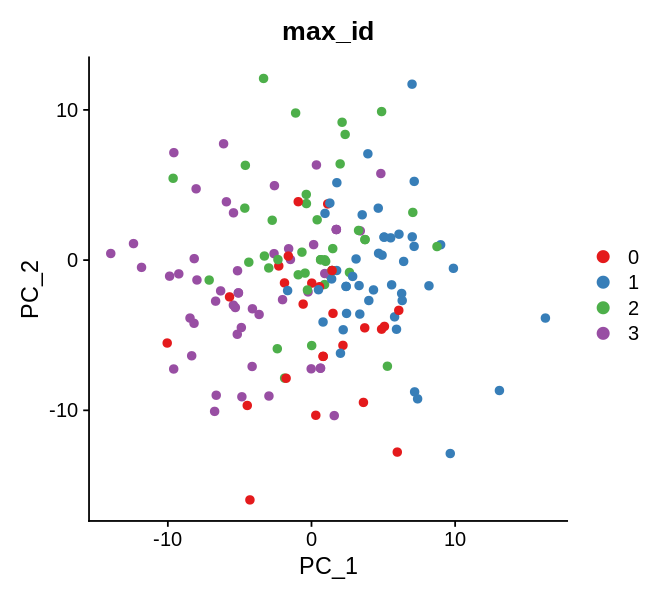

In [14]:
nmf<-read.delim( "./downsampling/H_bnmf_k6_4.tsv" )
rownames(nmf)<-nmf$X
normal@meta.data<-cbind(normal@meta.data,nmf[rownames(normal@meta.data),])
options(repr.plot.height=5,repr.plot.width=5.5)
DimPlot(normal, reduction = "pca",group.by='max_id',label=F,pt.size=2,cols=gsub('#FFFF33','grey',brewer.pal(7,"Set1")))

In [15]:
MMgroups$max_id<-nmf[MMgroups$newID,]$max_id
table(MMgroups$max_id)


 0  1  2  3 
26 47 40 50 

png 
  2

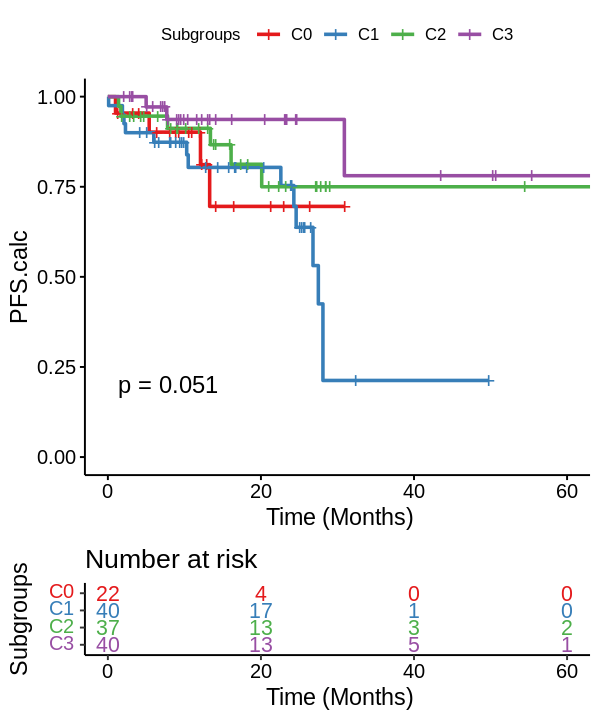

In [16]:
suppressMessages(p<-survplotPCD(data=MMgroups,status='Relapse',
                             time='PFS.calc',negative='No',positive='Yes',
                                                 group='max_id',labels=c("C0",'C1',"C2",'C3')))
p
pdf(file="MM.pdf",height=6,width=5)
p
dev.off()

In [17]:
MMgroups$max<-MMgroups$'max_id'
MMgroups$max<-gsub('0','others',MMgroups$max)
MMgroups$max<-gsub('2','others',MMgroups$max)
MMgroups$max<-gsub('3','others',MMgroups$max)

png 
  2

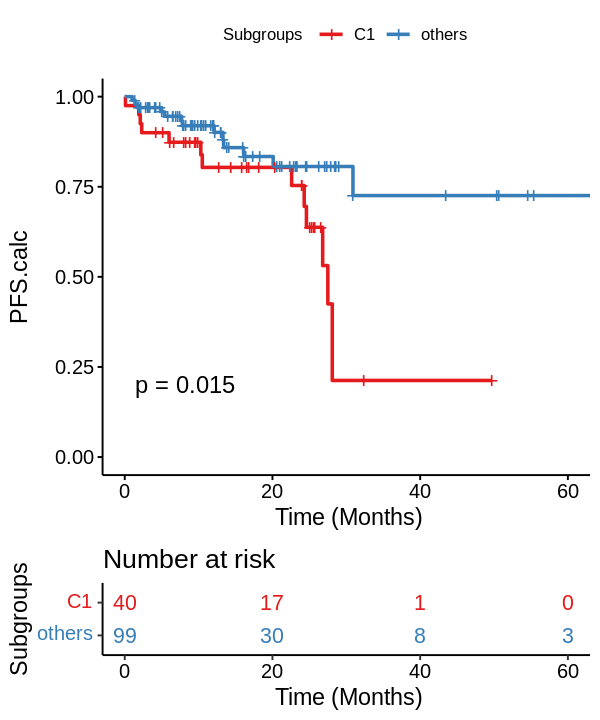

In [18]:
suppressMessages(p<-survplotPCD(data=MMgroups,status='Relapse',
                             time='PFS.calc',negative='No',positive='Yes',
                                                 group='max',labels=c('C1',"others")))
p
pdf(file="MMothers.pdf",height=6,width=5)
p
dev.off()

Warning message in survplotPCD(data = MMgroups, status = "Survival", time = "OS.calc", :
“NAs introduced by coercion”


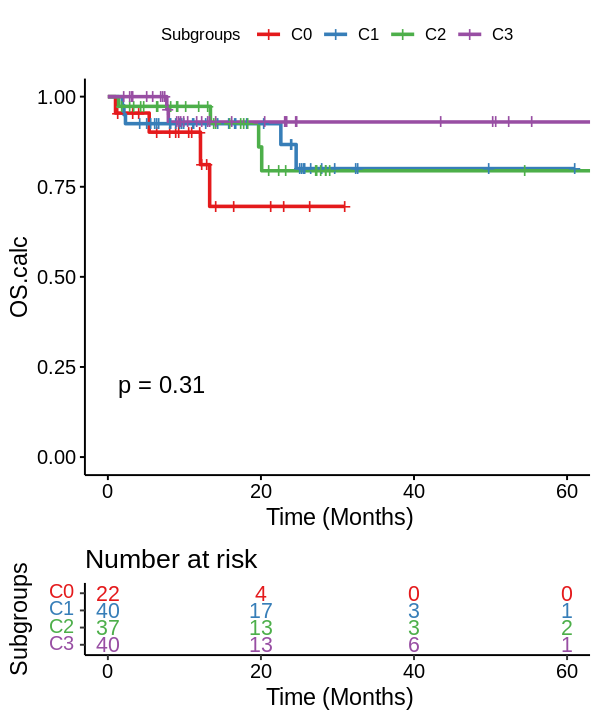

In [19]:
suppressMessages(p<-survplotPCD(data=MMgroups,status='Survival',
                             time='OS.calc',negative='Alive',positive='Died',
                                                     group='max_id',labels=c("C0",'C1',"C2",'C3')))
p

Warning message in wilcox.test.default(c(52, 64, 70, 72, 77, 49, 58, 54, 73, 67, :
“cannot compute exact p-value with ties”
Warning message in wilcox.test.default(c(52, 64, 70, 72, 77, 49, 58, 54, 73, 67, :
“cannot compute exact p-value with ties”
Warning message in wilcox.test.default(c(70, 62, 56, 39, 67, 53, 60, 71, 63, 67, :
“cannot compute exact p-value with ties”
Warning message in wilcox.test.default(c(52, 64, 70, 72, 77, 49, 58, 54, 73, 67, :
“cannot compute exact p-value with ties”
Warning message in wilcox.test.default(c(52, 64, 70, 72, 77, 49, 58, 54, 73, 67, :
“cannot compute exact p-value with ties”
Warning message in wilcox.test.default(c(70, 62, 56, 39, 67, 53, 60, 71, 63, 67, :
“cannot compute exact p-value with ties”


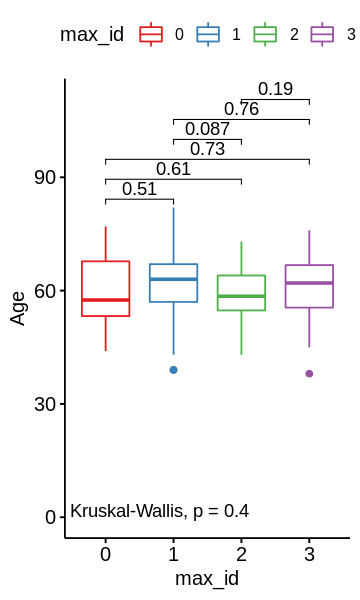

In [20]:
options(repr.plot.height=5,repr.plot.width=3)
ggboxplot(MMgroups, x="max_id", y="Age", color = "max_id")+
  stat_compare_means(label.y = 0)+
 scale_color_brewer(palette='Set1')+
stat_compare_means(comparisons = list( c("0", "1") , c("0", "2"),c("0", "3"),c("1", "2") , c("1", "3"),c("2", "3")))
ggsave(filename="MM1.pdf",height=5,width=3)

Warning message:
“Removed 4 rows containing non-finite values (stat_boxplot).”
Warning message:
“Removed 4 rows containing non-finite values (stat_compare_means).”
Warning message:
“Removed 4 rows containing non-finite values (stat_signif).”
Warning message in wilcox.test.default(c(11, 11, 3, 45, 30, 37, 31, 36, 17, 33, :
“cannot compute exact p-value with ties”
Warning message in wilcox.test.default(c(11, 11, 3, 45, 30, 37, 31, 36, 17, 33, :
“cannot compute exact p-value with ties”
Warning message in wilcox.test.default(c(11, 11, 3, 45, 30, 37, 31, 36, 17, 33, :
“cannot compute exact p-value with ties”
Warning message in wilcox.test.default(c(56, 21, 22, 2, 7, 70, 50, 3, 55, 11, 27, :
“cannot compute exact p-value with ties”
Warning message in wilcox.test.default(c(56, 21, 22, 2, 7, 70, 50, 3, 55, 11, 27, :
“cannot compute exact p-value with ties”
Warning message in wilcox.test.default(c(29, 35, 8, 4, 63, 80, 30, 63, 10, 14, 1, :
“cannot compute exact p-value with ties”
Warning messag

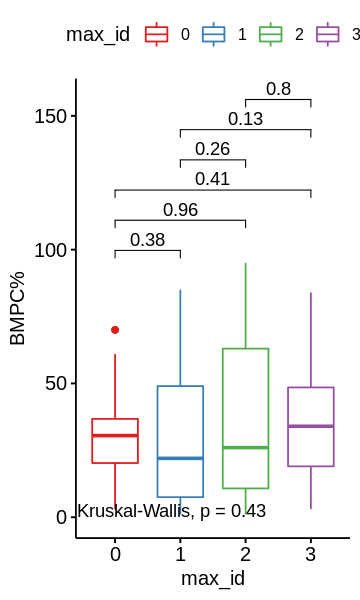

In [21]:
ggboxplot(MMgroups, x="max_id", y="BMPC%", color = "max_id")+
  stat_compare_means(label.y = 0)+
 scale_color_brewer(palette='Set1')+
stat_compare_means(comparisons = list( c("0", "1") , c("0", "2"),c("0", "3"),c("1", "2") , c("1", "3"),c("2", "3")))
ggsave(filename="MM2.pdf",height=5,width=3)

Warning message:
“Removed 10 rows containing non-finite values (stat_boxplot).”
Warning message:
“Removed 10 rows containing non-finite values (stat_compare_means).”
Warning message:
“Removed 10 rows containing non-finite values (stat_boxplot).”
Warning message:
“Removed 10 rows containing non-finite values (stat_compare_means).”


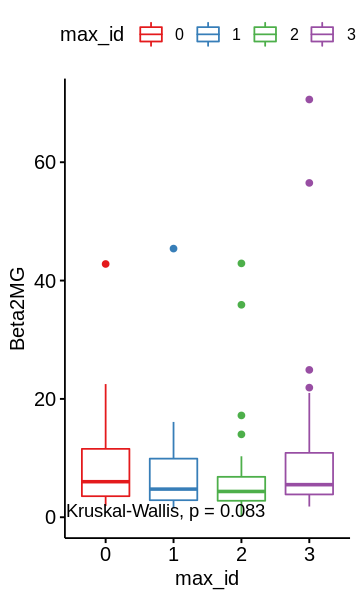

In [22]:
ggboxplot(MMgroups, x="max_id", y="Beta2MG", color = "max_id")+
  stat_compare_means(label.y = 0)+
 scale_color_brewer(palette='Set1')
ggsave(filename="MM3.pdf",height=5,width=3)

In [23]:
table(MMgroups$Therapy.1st)


BCD  BD DVD  ID IRD PAD RCd  Rd  TD VAD VRD VTD 
 54   4   2   3   2  10   1   6   2   1  53   6 

In [24]:
MMgroupsBCD<-MMgroups[which(MMgroups$Therapy.1st=='BCD'),]
as.data.frame(table(MMgroupsBCD[,c('Response.1st','max_id')]))

Response.1st,max_id,Freq
<fct>,<fct>,<int>
CR,0,1
MR,0,0
PD,0,0
PR,0,4
sCR,0,3
SD,0,2
VGPR,0,0
CR,1,1
MR,1,1


In [25]:
MMgroupsVRD<-MMgroups[which(MMgroups$Therapy.1st=='VRD'),]
as.data.frame(table(MMgroupsVRD[,c('Response.1st','max_id')]))

Response.1st,max_id,Freq
<fct>,<fct>,<int>
CR,0,0
MR,0,0
PD,0,0
PR,0,1
sCR,0,0
SD,0,0
VGPR,0,3
CR,1,2
MR,1,0
